<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Before you start

In order to complete the project you will need to create a developer account with OpenAI and store your API key as a secure environment variable. Instructions for these steps are outlined below.

### Create a developer account with OpenAI

1. Go to the [API signup page](https://platform.openai.com/signup). 

2. Create your account (you'll need to provide your email address and your phone number).

3. Go to the [API keys page](https://platform.openai.com/account/api-keys). 

4. Create a new secret key.

<img src="images/openai-new-secret-key.png" width="200">

5. **Take a copy of it**. (If you lose it, delete the key and create a new one.)

### Add a payment method

OpenAI sometimes provides free credits for the API, but this can vary depending on geography. You may need to add debit/credit card details. 

**This project should cost much less than 1 US cents with `gpt-4o-mini` (but if you rerun tasks, you will be charged every time).**

1. Go to the [Payment Methods page](https://platform.openai.com/account/billing/payment-methods).

2. Click Add payment method.

<img src="images/openai-add-payment-method.png" width="200">

3. Fill in your card details.

### Add an environmental variable with your OpenAI key

1. In the workbook, click on "Environment," in the top toolbar and select "Environment variables".

2. Click "Add" to add environment variables.

3. In the "Name" field, type "OPENAI_API_KEY". In the "Value" field, paste in your secret key.

<img src="images/datalab-env-var-details.png" width="500">

4. Click "Create", then you'll see the following pop-up window. Click "Connect," then wait 5-10 seconds for the kernel to restart, or restart it manually in the Run menu.

<img src="images/connect-integ.png" width="500">

### Update to Python 3.10

Due to how frequently the libraries required for this project are updated, you'll need to update your environment to Python 3.10:

1. In the workbook, click on "Environment," in the top toolbar and select "Session details".

2. In the workbook language dropdown, select "Python 3.10".

3. Click "Confirm" and hit "Done" once the session is ready.

1 - Create and store the embeddings
Embed the reviews using a suitable text embedding algorithm and store them as list in the variable embeddings.

2 - Dimensionality reduction & visualization
Apply an appropriate dimensionality reduction technique to reduce the embeddings to a 2-dimensional numpy array and store this array in the variable embeddings_2d.
Then, use this variable to plot a 2D visual representation of the reviews.

3 - Feedback categorization
Use your embeddings to identify some reviews that discuss topics such as 'quality', 'fit', 'style', 'comfort', etc.

4 - Similarity search function
Write a function that outputs the closest 3 reviews to a given input review, enabling a more personalized customer service response.
Apply this function to the first review "Absolutely wonderful - silky and sexy and comfortable", and store the output as a list in the variable most_similar_reviews.

## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

In [23]:
# Initialize your API key
import os
openai_api_key = os.environ["OPENAI_API_KEY"]

## Install useful libraries

In [24]:
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0'
except:
    !pip install openai==1.3.0
import openai

In [25]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [26]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [27]:
import plotly.express as px
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from scipy.spatial import distance
import numpy as np


reviews_texts = reviews['Review Text'].dropna()

client = openai.OpenAI(api_key=openai_api_key)
EMBEDDING_MODEL = "text-embedding-3-small"
response_dict = client.embeddings.create(input=reviews_texts.tolist(), model=EMBEDDING_MODEL).model_dump()

embeddings = [response["embedding"] for response in response_dict["data"]]

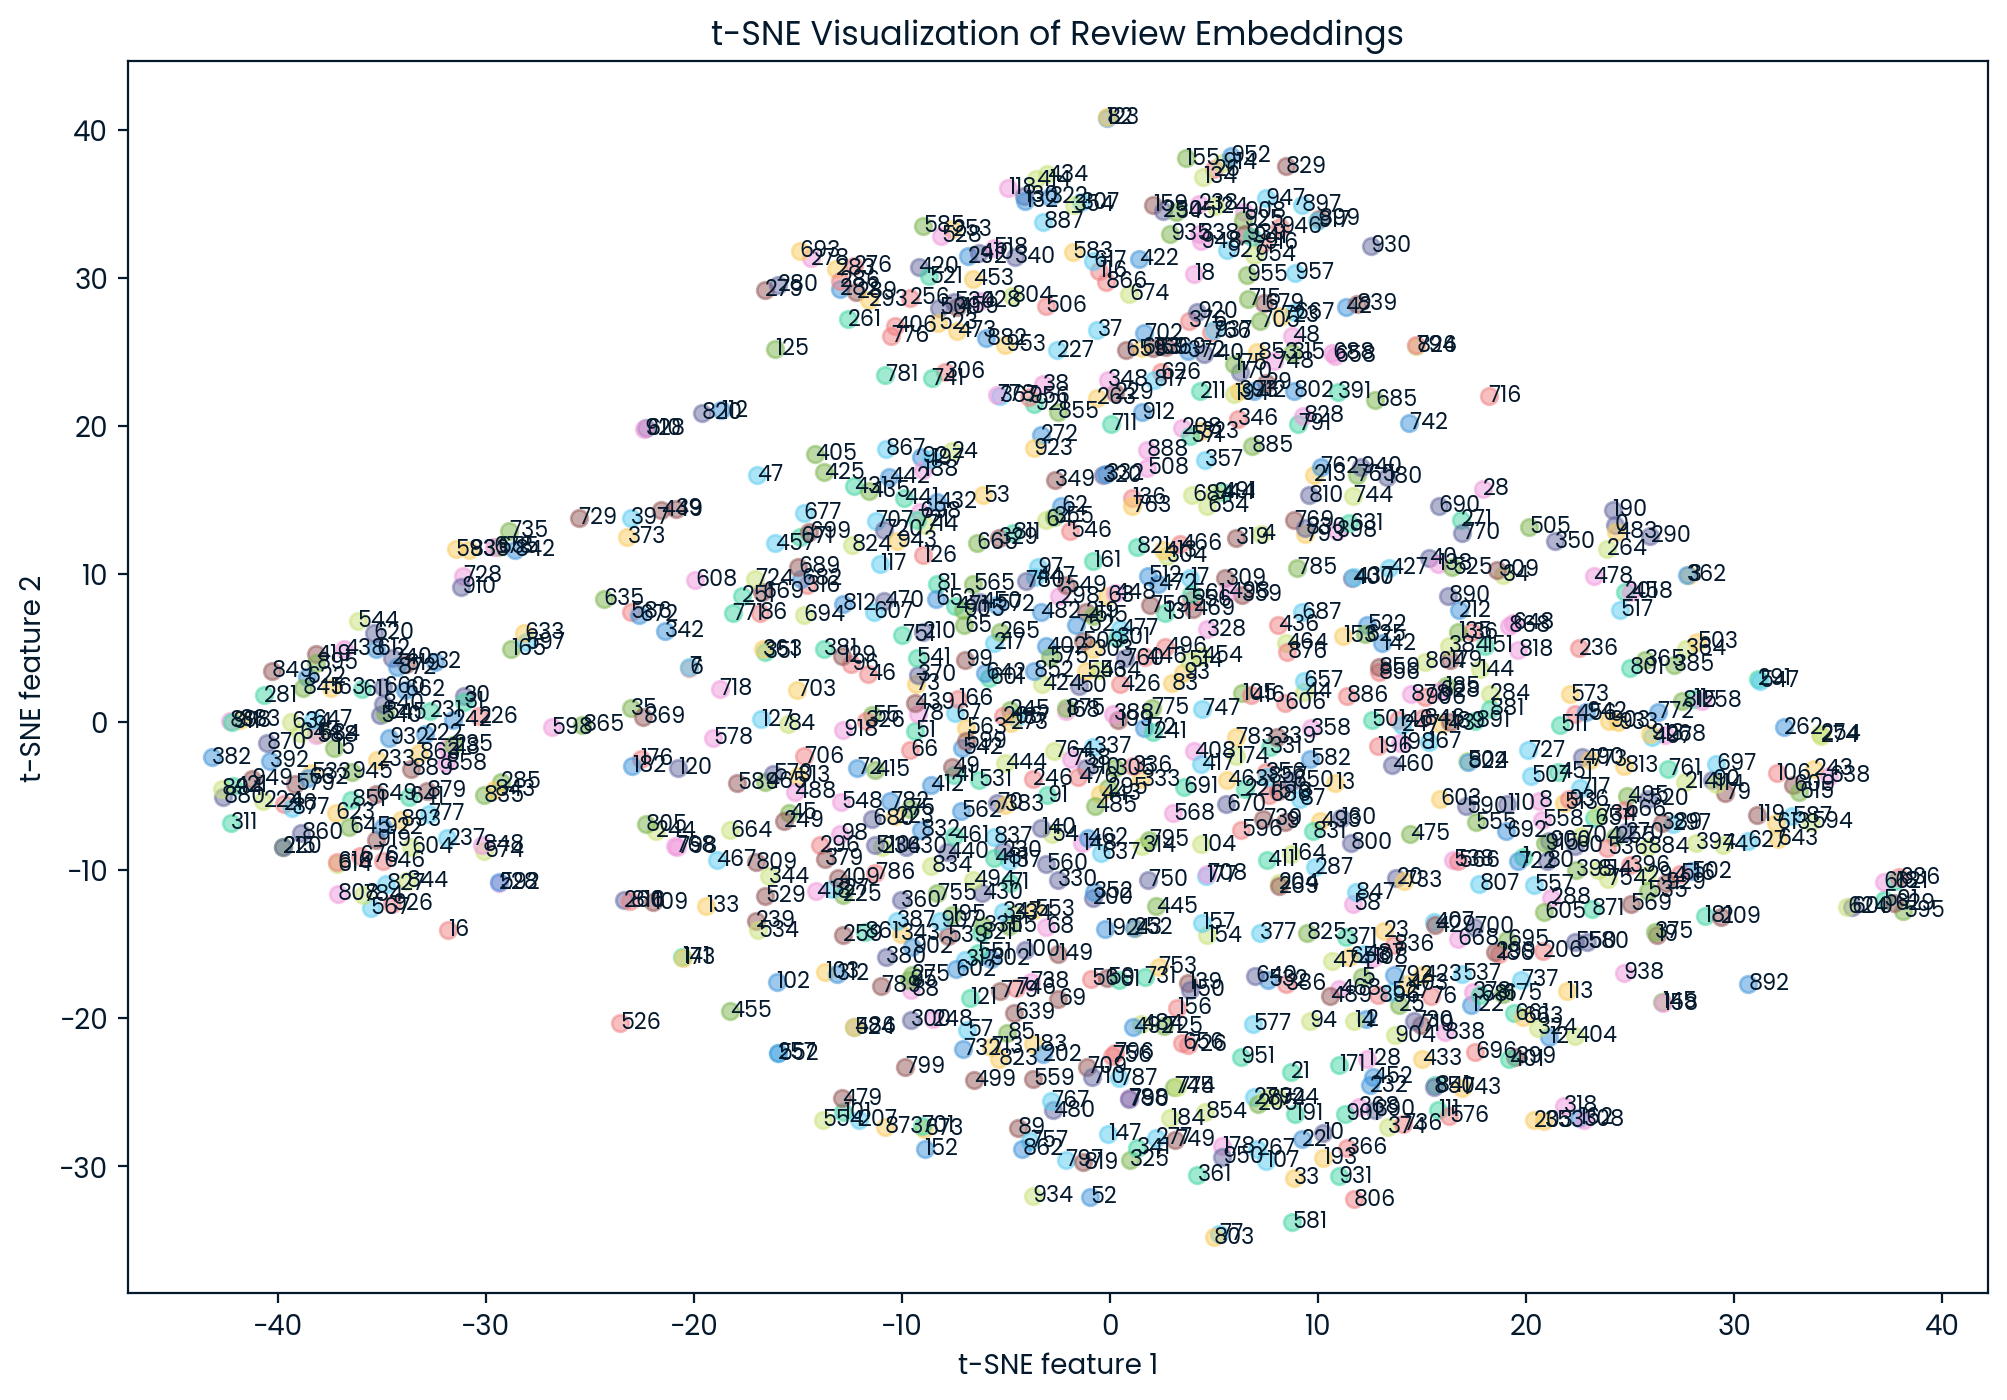

In [28]:
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

embeddings_2d = apply_tsne(np.array(embeddings))

def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8, verticalalignment='center')
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d)

In [ ]:
categories = ["Quality", "Fit", "Style", "Comfort"]

category_responses = client.embeddings.create(input=categories, model=EMBEDDING_MODEL).model_dump()
category_embeddings = [embedding["embedding"] for embedding in category_responses["data"]]

def categorize_feedback(text_embedding, category_embeddings):
    similarities = [{"distance": distance.cosine(text_embedding, cat_emb), "index":i}
                     for i, cat_emb in enumerate(category_embeddings)]
    closest = min(similarities, key=lambda x: x["index"])
    return categories[closest["index"]]

feedback_categories = [categorize_feedback(embedding, category_embeddings) for embedding in embeddings]

client = chromadb.PersistentClient()

review_embeddings_db = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))

review_embeddings_db.add(
    documents=review_texts.tolist(),
    ids=[str(i) for i in range(len(review_texts))]
)

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/usr/local/lib/python3.8/dist-packages/google/protobuf/internal/__init__.py)

In [ ]:
example_review = "Absolutely wonderful - silky and sexy and comfortable"

def find_n_closest(input_text, vector_db, n=3):
    collection = client.get_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))
    results = collection.query(
        query_texts=[input_text],
        n_results=n
    )
    return results

most_similar_reviews = find_n_closest(example_review,review_embeddings_db,3)
print(most_similar_reviews)
client.delete_collection(name="review_embeddings")

NameError: name 'review_embeddings_db' is not defined